In [4]:
# load necessary libraries for ETL
import numpy as np
import pandas as pd
import requests
import requests
import urllib
import sqlalchemy
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
'''
@article{hou2024bridging,
  title={Bridging Language and Items for Retrieval and Recommendation},
  author={Hou, Yupeng and Li, Jiacheng and He, Zhankui and Yan, An and Chen, Xiusi and McAuley, Julian},
  journal={arXiv preprint arXiv:2403.03952},
  year={2024}
}
'''
file_meta = "../DATA/movies_metadata_reduced.jsonl"
meta_list = [json.loads(line) for line in open(file_meta, 'r')]


file_rev = "../DATA/movies_reviews_reduced.jsonl"
rev_list = [json.loads(line) for line in open(file_rev, 'r')]
rev_list[0]


{'rating': 5.0,
 'title': 'Must watch!',
 'text': 'I love this series!',
 'parent_asin': 'B00PSLQYWE'}

In [6]:
# make a data frame for the reviews 
rev_df = pd.DataFrame(rev_list)
rev_df.head()


,rating,title,text,parent_asin
0,5.0,Must watch!,I love this series!,B00PSLQYWE
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG


In [7]:
# make a data frame for the metadata? 
# dropping movies that don't have a title
meta_df = pd.DataFrame(meta_list).drop(columns=['images', 'videos','subtitle','description', 'price', 'bought_together', 'title', 'categories','author', 'store', 'features'])
meta_df.head()
meta_df.isna().sum()

main_category     351
average_rating      3
rating_number       3
details             0
parent_asin         0
dtype: int64

In [8]:
print(len(meta_df))
print(len(meta_df[meta_df['main_category'] == 'Prime Video']))
print(len(meta_df[meta_df['main_category'] == 'Movies & TV']))
prime_df = meta_df[meta_df['main_category'] == 'Prime Video']


7477
3488
3612


In [9]:
prime_df['average_rating'].corr(prime_df['rating_number'])
prime_df.head()
#meta_df.isna().sum()

,main_category,average_rating,rating_number,details,parent_asin
0,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ...",B0728FHHYC
2,Prime Video,3.1,8.0,"{'Audio languages': ['English'], 'Subtitles': ...",B00O8NP6XQ
5,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ...",B077QNR8Q6
7,Prime Video,4.1,165.0,"{'Content advisory': ['Violence', 'substance u...",B09CZJW2Q9
10,Prime Video,4.3,38.0,"{'Subtitles': ['None available'], 'Directors':...",B071L45H6W


In [10]:
df_merged = rev_df.merge(prime_df, on='parent_asin', how='right')
df_merged.head()
# aughhhh the colums are not merging right aauughhhh

,rating,title,text,parent_asin,main_category,average_rating,rating_number,details
0,3.0,Predictable but with promise,It had a pacing problem. It was slow in parts ...,B0728FHHYC,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ..."
1,1.0,One Star,Did not really like this movie. It was a bit o...,B00O8NP6XQ,Prime Video,3.1,8.0,"{'Audio languages': ['English'], 'Subtitles': ..."
2,5.0,Five Stars,fun,B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."
3,4.0,Worth the time,"Falls short of the book, of course, but a good...",B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."
4,5.0,Be ready to have your heart racing as quickly ...,I read the book on which this series is based....,B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."


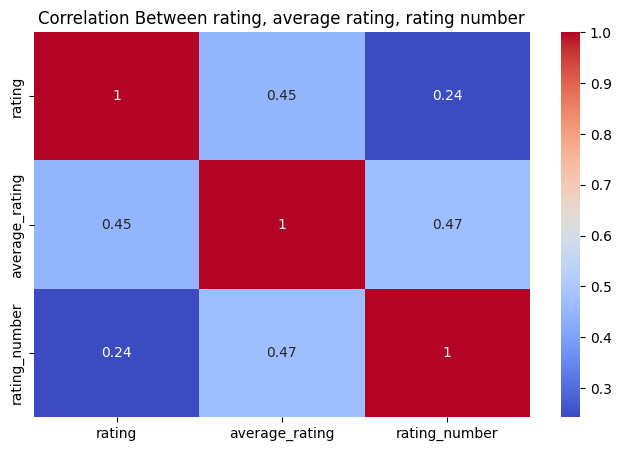

In [11]:
corr_df = df_merged.select_dtypes(include=['float64'])
correlation_matrix = corr_df.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between rating, average rating, rating number')
plt.show()


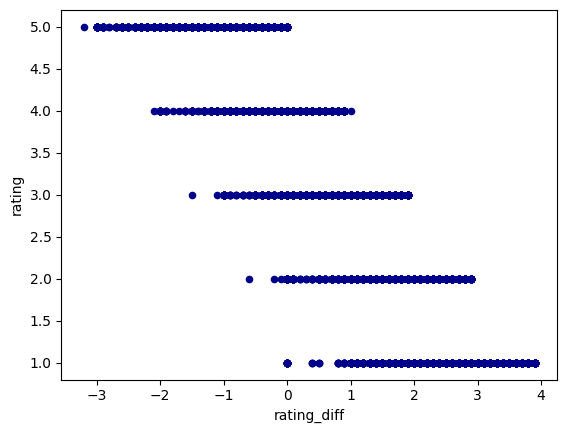

In [12]:
# take count of descriptors im in the details column

# postive diff = user is lower than average, negative diff = user is higher than average 
df_merged['rating_diff'] = df_merged['average_rating'] - df_merged['rating']
ax1 = df_merged.plot.scatter(x='rating_diff',

                      y='rating',

                      c='DarkBlue')

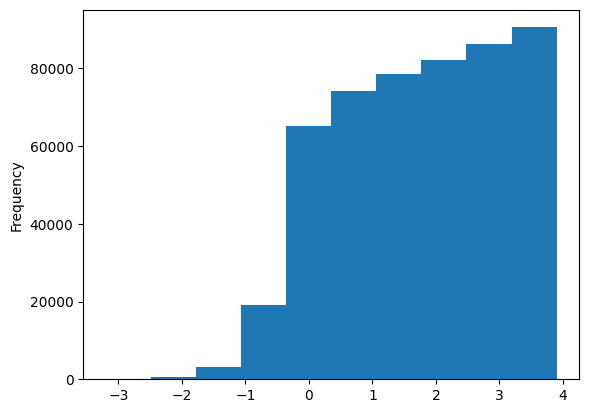

In [13]:
ax = df_merged["rating_diff"].plot.hist(orientation="vertical", cumulative=True)
# postive diff = user is lower than average, negative diff = user is higher than average 


In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ethanogilvie/nltk_data...


In [22]:
def get_sentiment_scores(df):
    # Create an empty list to store sentiment scores
    sentiment_scores = []

    # Iterate over each review text
    for review in df["text"]:
        sentiment = sia.polarity_scores(str(review))  # Convert to string & analyze
        sentiment_scores.append(sentiment["compound"])  # Extract compound score

    # Add sentiment score column
    df["sentiment_score"] = sentiment_scores

    return df  


In [23]:
rev_df_s = get_sentiment_scores(rev_df)
rev_df_s.head(100)

,rating,title,text,parent_asin,sentiment_score
0,5.0,Must watch!,I love this series!,B00PSLQYWE,0.6696
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02,0.8748
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G,0.7906
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2,0.9825
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG,0.6908
...,...,...,...,...,...
95,3.0,Not quite right in interpetation of biblical p...,I gave it a 3. You really have to know your Bi...,B0847V9B7K,0.8869
96,3.0,Pride Fighting Championships 29: Fists of Fluf...,"As usual, Pride puts on another great show. Ye...",B000CSTKJW,0.9969
97,2.0,Jason dies and is reborn into movie hell,I have always been a fan of the Friday the 13t...,B00006FDBT,0.2365
98,5.0,"I won't be popular for my review, but here goe...",Maybe I just LOVE the grittiness and despair i...,B000O77SF4,0.9896
